# <font color='brown'>楼 + 机器学习实战</font>

# 挑战：使用 CNN 实现猫狗识别

## 挑战介绍

上一个实验中，我们对卷积神经网络有了一定的认识，也搭建了一个卷积神经网络完成了手写识别的学习任务，更熟悉了一些经典的卷积神经网络。本次挑战，我们需要把学到的知识运用起来。现在，挑战提供了一组数据集包含猫和狗的图片，你需要试着搭建卷积神经网络完成猫狗识别任务。 

## 挑战知识点

- TensorFlow 运用
- 卷积神经网络实践

---

## 挑战内容

卷积神经网络用于图像识别非常合适。本次挑战中，我们将尝试搭建卷积神经网络来完成经典的猫狗识别任务。

挑战所用到数据集源于 Kaggle 猫狗识别大赛，训练集一共有 `25000` 标记后的猫狗照片。我们需要对这些照片进行处理，并训练一个卷积神经网络，最后在测试集上进行验证。

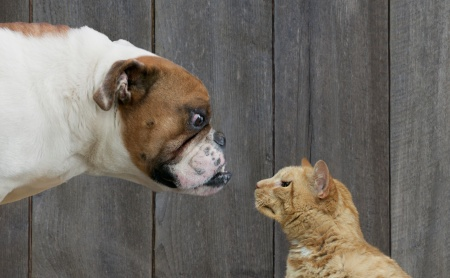

### 数据集预处理

首先，我们需要下载挑战所用到的数据集，并完成数据解压：

In [ ]:
!wget http://labfile.oss.aliyuncs.com/courses/1081/dogs_cats.zip # 下载数据
!unzip dogs_cats.zip # 解压数据

数据集较大，请耐心等待。挑战提供的图片文件名的格式为 `cat.10.jpg` 或者 `dog.20.jpg` 样式，中间的数字为序号。所以，我们需要对图片进行标记，这里使用独热编码的方式，猫 cat 被标记为 `[1, 0]`，狗 dog 被标记为 `[0, 1]`。

由于图片较多，这里我们会使用到 `tqdm` 的模块将处理过程可视化为进度条。该模块在这类场景中非常实用，介绍给大家。同时，下面我们会用到 Open CV 对图像进行预处理，首先安装这两个模块。

In [ ]:
# 安装必要模块
!pip install tqdm
!pip install opencv-python

In [ ]:
import os
import cv2
import numpy as np
from random import shuffle
from tqdm import tqdm

def image_label(image):
    """对图片进行独热标记
    """
    label = image.split('.')[-3]
    if label == 'cat':
        return [1, 0]
    elif label == 'dog':
        return [0, 1]

def image_preprocess(dir_path='train'):
    """图片预处理
    """
    data = []
    for img in tqdm(os.listdir(dir_path)): # 调用 tqdm 可视化循环处理过程
        img_path = os.path.join(dir_path, img)
        img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 使用 opencv 将图片处理成灰度矩阵
        img_data = cv2.resize(img_data, (64, 64)) # 图片处理成统一大小
        data.append([np.array(img_data), image_label(img)])
    shuffle(data) # 随机打乱
    np.save('data.npy', data) # 存放处理后的 numpy 数组，方便下次使用
    return data

定义完图片预处理函数，接下来就运行并将图片处理成 numpy 数组，以便于可以输入神经网络训练。

In [ ]:
data = image_preprocess('train') # 解压后文件夹名为 train

预处理的函数中，我们使用 `np.save()` 将 numpy 数组保存下来。一般情况下，为了避免大量图片转换带来的时间损失，如需重复运行时，可以直接读取相应的数组文件。当然，由于上面已经对 `data` 进行了赋值，这步操作并不是必须的。当下次运行时，即无需重复运行上面的代码。

In [ ]:
data = np.load('data.npy') # 加载预处理好的数组文件

你可以自行输出 `data` 查看数据结构，其实就是一张图片对应着一个标签。接下来，我们将数据划分为训练集和测试集。对于 `25000` 张图片而言，这里将 `20000` 张划为训练集，另外 `5000` 张作为测试集。

In [ ]:
train_data = data[:-5000] # 训练集
test_data = data[-5000:] # 测试集

划分之后，将训练集的特征数组及标签数组分别分离出来。这里需要对特征数组进行 `reshape` 操作，以便于能顺利输入神经网络模型。关于这个操作，在前面实验中已经有过讲解了。

In [ ]:
X_train = np.array([i[0] for i in train_data]).reshape(-1, 64, 64, 1) # 训练集特征
y_train = np.array([i[1] for i in train_data]) # 训练集标签

X_test = np.array([i[0] for i in test_data]).reshape(-1, 64, 64, 1) # 测试集特征
y_test = np.array([i[1] for i in test_data]) # 测试集标签

len(X_train), len(y_train), len(X_test), len(y_test)

### 构建卷积神经网络模型

终于，我们可以开始搭建卷积神经网络了。本次挑战中，依然采用之前的卷积层 + 池化层堆叠，最后连接上几个全连接层得到输出的形式。挑战拟搭建卷积神经网络结构如下：

- 第一层卷积层，卷积核大小 $3\times3$，包含 32 个卷积核，`same padding` 形式，`relu` 激活；
- 第一层池化层，池化大小 $2\times2$， 步长为 `1`，`valid padding` 形式；


- 第二层卷积层，卷积核大小 $3\times3$，包含 64 个卷积核，`same padding` 形式，`relu` 激活；
- 第二层池化层，池化大小 $2\times2$，步长为 `1`，`valid padding` 形式；


- 第三层卷积层，卷积核大小 $3\times3$，包含 128 个卷积核，`same padding` 形式，`relu` 激活；
- 第三层池化层，池化大小 $2\times2$，步长为 `2`，`valid padding` 形式；


- 全连接层，`128` 的输出，注意要将第三层池化层平铺送入第一层全连接层；
- Dropout 层，概率设为 `0.6`；
- 全连接层输出，由于是猫狗的判断输出，则输出大小为 `2`。

为了帮助大家更全面了解 TensorFlow 的使用，本次挑战不使用 `tf.nn` 下的神经网络层类，而是使用 `tf.layers` 下更高层的 API 。

---

**<font color='red'>挑战</font>：参考上面给出的神经网络结构，使用 `tf.layers` 下的类构建神经网络模型。** [官方文档](https://www.tensorflow.org/api_docs/python/tf/layers)

**<font color='blue'>规定</font>**：上文结构中未提到的参数选用默认即可。

In [ ]:
import tensorflow as tf


### 代码开始 ### (≈ 12 行代码)

# 图片是 64*64 大小，但是数量未知，所以数量的维度为 None
x = tf.placeholder(tf.float32, [None, 64, 64, 1])
y = tf.placeholder(tf.int64, [None, 2])

# 卷积 + 池化 1
conv1 = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[3, 3],
                         padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=1)

# 卷积 + 池化 2
conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[3, 3], 
                         padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=1)

# 卷积 + 池化 3
conv3 = tf.layers.conv2d(inputs=pool2, filters=128, kernel_size=[3, 3], 
                         padding="same", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

# 全连接层
flatten = tf.layers.flatten(pool3)
dense = tf.layers.dense(inputs=flatten, units=128, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=dense, rate=0.6)
logits = tf.layers.dense(inputs=dropout, units=2, activation=None) # 输出

### 代码结束 ###

**运行测试：**

In [ ]:
logits

**期望输出：**

`<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 2) dtype=float32>`

---

**<font color='red'>挑战</font>：定义损失函数、优化器、以及准确率评估函数。**

**<font color='blue'>规定</font>**：

- 使用交叉熵损失函数，可以参考实验内容。
- 学习率设为 `0.001`。
- 准确率公式参考实验内容。

**<font color='green'>提示</font>：**你可能会使用到的方法有：

- `tf.reduce_mean()`: 计算平均值。
- `tf.argmax()`: 返回张量最大值索引。
- `tf.cast()`: 张量数据类型转换。
- `tf.nn.in_top_k()`: 判断结果是否在 top k 的预测之中。

In [ ]:
### 代码开始 ### (≈ 3 行代码)

# 损失函数
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))

# 优化器
training_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) 

# 准确率计算公式
acc_func = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, tf.argmax(y, 1), 1), tf.float32))

### 代码结束 ###

### 模型训练及评估

接下来我们就可以建立会话开始运行，这部分代码和实验内容中相似。特别注明的是，由于测试集太大无法一次性传入模型，这里通过随机抽样的额方式在测试数据上进行验证。

In [ ]:
from matplotlib import pyplot as plt
from IPython import display # 引入 display 模块目的方便程序运行展示
import random
%matplotlib inline

batch_size = 32 # 批量大小

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print('训练开始，请耐心等候')
    
    for epoch in range(5):
        train_acc_list = [] # 为了绘图
        test_acc_list = [] # 为了绘图
        # 获取批量
        train_batch = zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train) + 1, batch_size))
        i = 1
        for start, end in train_batch:
            sess.run(training_op, feed_dict={x: X_train[start:end], y: y_train[start:end]}) # 传入数据
            train_acc = acc_func.eval(feed_dict={x: X_train[start:end], y: y_train[start:end]}) # 训练集准确率
            
            test_index = random.sample(range(len(y_test)), batch_size) # 随机抽样一个 batch 大小的测试集
            test_acc = acc_func.eval(feed_dict={x: X_test[test_index], y: y_test[test_index]}) # 测试集准确率
            
            # 以下是绘图代码
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            
            display.clear_output(wait=True)
            plt.style.use('ggplot')
            plt.figure(figsize=(12, 8))
            plt.plot(train_acc_list, label='train_accuracy')
            plt.plot(test_acc_list, label='test_accuracy')
            plt.legend()
            plt.title("epoch: {}, batch:{}, train_accuracy: {}, test_accuracy: {}".format(epoch+1, i, 
                                                                                          train_acc, test_acc))
            plt.show()
            i+=1

经过测试，`5` 个 Epoch 迭代之后，可以在训练集及测试集上得到近 `70% ～ 80%` 的准确率。

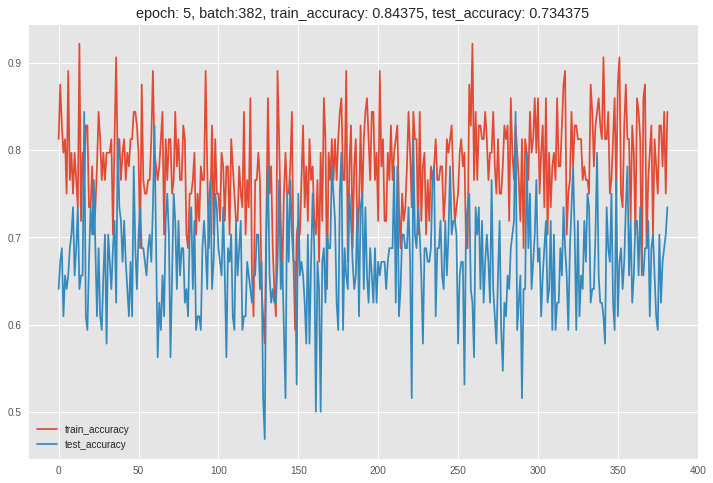

其实这个准确率并不理想，在 Kaggle 的比赛中，较好成绩都能得到超过 `95%` 的准确率。归结其原因大致有如下几点：

1. 为了控制训练时间，卷积网络结构较为简单，一些表现较好的网络通常需要训练数十个小时。
2. 数据预处理方式简单，这里对图像大小进行了严格控制，并只保留一个色彩通道。
3. 未针对数据集扩充，为了得到表现较好的模型，通常会提前对数据集进行变换处理，使得数据集大小扩充数倍。

有兴趣的同学可以根据以上几点原因进行改进。同时，为了快速得到更好的结果，我们往往会直接拆解 `VGG`, `ResNet` 在 ImageNet 上得到的预训练模型，并使用迁移学习的手段进行训练。通常，这样能得到 `98%` 以上的识别准确率。关于迁移学习的内容，后续会补充介绍。

---

<div style="color: #999;font-size: 12px;font-style: italic;">*本课程内容，由作者授权实验楼发布，未经允许，禁止转载、下载及非法传播。</div>